# 1 Configuration

## 1.1 Import Libraries

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))

Python ver: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1


In [2]:
def heatMap(df,max=1,min=-1):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=bool),1)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

def findCorrelatedColumns(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append({"C1":i,"C2":j,"Corr":corr[i][j]})
    return pairs

def findHighCorrelation(df,minThreshold,target):
    corr = df.corr()
    pairs = []

    for j in corr[target][abs(corr[target])>=minThreshold].index:
        if target != j:
            pairs.append({"Name":j,"Corr":corr[target][j]})
    return pairs

## 1.2 Pre configurations

In [3]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [4]:
AimoScoreFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/20190108%20scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)


## 2.2 Merging the two datasets

### 2.2.1 Join the two tables via their ID

In [5]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


### 2.2.2 Find the weakest link for each data point
Finding the column with the maximum score in each row and adding its name as a new column

In [6]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

### 2.2.3 Discard extra columns
Discard the 14 weak link scores from the joint table

In [7]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

### 2.2.4 Remove Duplicates

In [8]:
result = result.drop_duplicates(subset="ID")

In [9]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

### 2.2.5 Remove clusters with very few samples 

In [10]:
temp = (result["WeakLinks"].value_counts()<10)
temp = temp[~temp == False]
result = result[~result["WeakLinks"].isin(temp.index)]
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64

In [11]:
result[["ID","SCORE","AimoScore","WeakLinks"]]

,ID,SCORE,AimoScore,WeakLinks
0,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,0.323667,0.323667,RightShoulderElevation
1,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,0.323699,0.323699,RightArmFallForward
2,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,0.848327,0.848327,LeftArmFallForward
3,00607608-6f2f-459b-a69d-e14067489459.Kinect,0.351332,0.351332,RightShoulderElevation
4,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,0.627181,0.627181,ForwardHead
...,...,...,...,...
2086,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,0.665494,0.665494,RightArmFallForward
2087,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,0.830883,0.830883,LeftArmFallForward
2088,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,0.527640,0.527640,LeftArmFallForward
2090,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,0.407197,0.407197,RightKneeMovesOutward


## 2.3 Removing the identical variables

In [12]:
pairs = findCorrelatedColumns(result,1)
pairs

[{'C1': 'AimoScore', 'C2': 'SCORE', 'Corr': 1.0},
 {'C1': 'No_1_Angle_Deviation', 'C2': 'No_3_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_Angle_Deviation', 'C2': 'No_1_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_7_Angle_Deviation', 'C2': 'No_2_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_10_Angle_Deviation', 'C2': 'No_4_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_13_Angle_Deviation', 'C2': 'No_5_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_1_NASM_Deviation', 'C2': 'No_5_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_2_NASM_Deviation', 'C2': 'No_7_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_3_NASM_Deviation', 'C2': 'No_1_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_4_NASM_Deviation', 'C2': 'No_10_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_NASM_Deviation', 'C2': 'No_13_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'SCORE', 'C2': 'AimoScore', 'Corr': 1.0}]

In [13]:
result = result.drop(
    columns=[
        "No_1_Angle_Deviation",
        "No_5_Angle_Deviation",
        "No_7_Angle_Deviation",
        "No_10_Angle_Deviation",
        "No_13_Angle_Deviation",
        "SCORE"
    ]
)

## 2.4 Removing the symmetric variables 
We assume that any variable with a correlation higher than 80 percent would be a symmetric variable

In [14]:
pairs = findCorrelatedColumns(result,0.8)
pairs

[{'C1': 'No_1_NASM_Deviation',
  'C2': 'No_2_NASM_Deviation',
  'Corr': 0.8491413141954607},
 {'C1': 'No_2_NASM_Deviation',
  'C2': 'No_1_NASM_Deviation',
  'Corr': 0.8491413141954607},
 {'C1': 'No_4_NASM_Deviation',
  'C2': 'No_5_NASM_Deviation',
  'Corr': 0.904593644698089},
 {'C1': 'No_5_NASM_Deviation',
  'C2': 'No_4_NASM_Deviation',
  'Corr': 0.904593644698089},
 {'C1': 'No_8_NASM_Deviation',
  'C2': 'No_9_NASM_Deviation',
  'Corr': 0.8742235883032127},
 {'C1': 'No_9_NASM_Deviation',
  'C2': 'No_8_NASM_Deviation',
  'Corr': 0.8742235883032127},
 {'C1': 'No_11_NASM_Deviation',
  'C2': 'No_12_NASM_Deviation',
  'Corr': 0.8645293700913619},
 {'C1': 'No_12_NASM_Deviation',
  'C2': 'No_11_NASM_Deviation',
  'Corr': 0.8645293700913619},
 {'C1': 'No_1_Time_Deviation',
  'C2': 'No_2_Time_Deviation',
  'Corr': 0.9390442066679106},
 {'C1': 'No_2_Time_Deviation',
  'C2': 'No_1_Time_Deviation',
  'Corr': 0.9390442066679106}]

In [15]:
result = result.drop(
    columns=[
        "No_1_NASM_Deviation",
        "No_5_NASM_Deviation",
        "No_9_NASM_Deviation",
        "No_11_NASM_Deviation",
        "No_2_Time_Deviation"
    ]
)

## 2.5 Discard extra columns

In [16]:
result = result.drop(
    columns=[
        "ID",
        "Date",
        "EstimatedScore"
    ]
)

### Testing and Traing sets

In [198]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.3

y_train,y_test ,X_train, X_test  = train_test_split(result[["WeakLinks","AimoScore"]], result.drop(columns=["WeakLinks","AimoScore"]), train_size = trainingPercent)

# 3 Create the linear model

## 3.1  Check with 10-Fold Cross-Validation

In [246]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

minCorrelationSteps = [0.4,0.35,0.3,0.25]

# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
cvResults = pd.DataFrame()
y = y_train["AimoScore"]
columns = []

for minCorrelation in minCorrelationSteps:
    print(minCorrelation)
    for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])

    X = X_train[columns]
    errors = []
    for i in range(0, 4):
        pipe = make_pipeline(PolynomialFeatures(degree = i),LinearRegression())
        cv_scores = cross_val_score(pipe, X, y, scoring = "neg_mean_squared_error", cv = kfolds)
        errors.append(abs(cv_scores.mean()))
        
    cvResults[minCorrelation] = errors


0.4
0.35
0.3
0.25


In [247]:
cvResults

,0.40,0.35,0.30,0.25
0,NaN,NaN,NaN,NaN
1,0.034266,0.034074,0.029541,0.027644
2,0.030213,0.030360,0.028107,0.027090
3,0.028970,0.029124,0.036018,0.045696


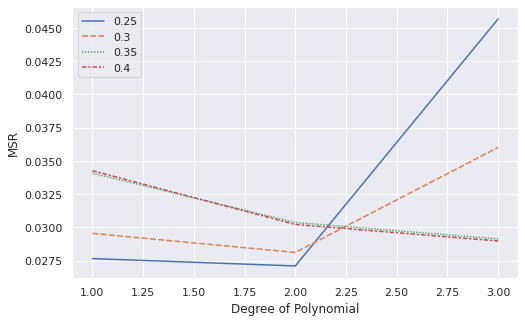

In [248]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=cvResults,ax=ax)

# Add labels to plot
plt.xlabel("Degree of Polynomial")
plt.ylabel("MSR")

plt.show()

## 3.2 A new Candidate 
we choose all possible predictors that have more than 20% corelation with AimoScore and have used a 3 degree of polynomial regression model

In [249]:
findHighCorrelation(result.drop(columns=["WeakLinks"]),0.25,"AimoScore")

[{'Name': 'No_6_Angle_Deviation', 'Corr': -0.30923062005392127},
 {'Name': 'No_8_Angle_Deviation', 'Corr': -0.3082475278498833},
 {'Name': 'No_11_Angle_Deviation', 'Corr': -0.3037189875513421},
 {'Name': 'No_12_Angle_Deviation', 'Corr': -0.3255914885172604},
 {'Name': 'No_4_NASM_Deviation', 'Corr': -0.3753175628220183},
 {'Name': 'No_10_NASM_Deviation', 'Corr': -0.41741226434432943},
 {'Name': 'No_12_NASM_Deviation', 'Corr': -0.4878398017661141},
 {'Name': 'No_17_NASM_Deviation', 'Corr': -0.26339714917816287},
 {'Name': 'No_22_NASM_Deviation', 'Corr': -0.2575425456836188}]

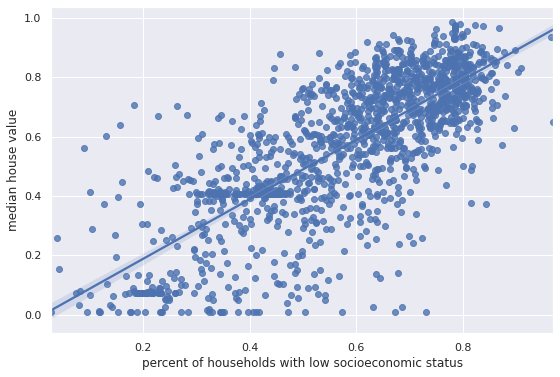

r = 0.763 , p < 5.143744767475649e-279


In [245]:
minCorrelation = 0.25

#y = result["AimoScore"]
y = y_train["AimoScore"]

columns = []

for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])
        
#X_1 = result[columns]
X_1 = X_train[columns]

pipe = make_pipeline(PolynomialFeatures(2),LinearRegression())
polyreg = pipe.fit(X_1, y)
predicted_1 = polyreg.predict(X_test[columns])


res = pd.DataFrame({"Original":y_test["AimoScore"],"Predicted":predicted_1})


fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.3 The original model
This is our previous linear model with adjusted r-squared of 0.705

In [252]:
def createExtraPredictors(df):
    X_3 = df.drop(columns=[])
    X_3["A4*N12"] = X_3["No_4_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["A8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N2*N20"] = X_3["No_2_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N13"] = X_3["No_12_NASM_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["N12*N15"] = X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N12*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N12*N20"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N20*N22"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_22_NASM_Deviation"]
    X_3["N12*N20*N19"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N20*N19*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]* X_3["No_16_NASM_Deviation"]
    X_3["N12*N23"] = X_3["No_12_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["N21*N24"] = X_3["No_21_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["T1*N13"] = X_3["No_1_Time_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["T1*N2"] = X_3["No_1_Time_Deviation"] * X_3["No_2_Angle_Deviation"]
    X_3["T1*N18"] = X_3["No_1_Time_Deviation"] * X_3["No_18_NASM_Deviation"]
    X_3["N4*N10*N12"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N4*N10*N12*N15"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["A11*N12"] = X_3["No_11_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N15"] = X_3["No_8_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N15*N20"] = X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N14*N15*N20*N21"] = X_3["No_14_NASM_Deviation"] *X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_21_NASM_Deviation"]
    X_3["N4*N10"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"]
    X_3["N4**2"] = X_3["No_4_NASM_Deviation"] ** 2
    X_3["N8**2"] = X_3["No_8_NASM_Deviation"] ** 2
    X_3["N10**2"] = X_3["No_10_NASM_Deviation"] ** 2
    X_3["N10**3"] = X_3["No_10_NASM_Deviation"] ** 3
    X_3["N8**"] = X_3["No_8_NASM_Deviation"] ** 3
    X_3["N8**4"] = X_3["No_8_NASM_Deviation"] ** 4
    X_3["N8**5"] = X_3["No_8_NASM_Deviation"] ** 5
    X_3["N4*N14"] = X_3["No_4_NASM_Deviation"] * X_3["No_14_NASM_Deviation"]
    X_3["N20*N24"] = X_3["No_20_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["N21*N23"] = X_3["No_21_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["T1*N21*N23"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]
    X_3["T1*N21*N23*N12"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"] * X_3["No_12_NASM_Deviation"]
    X_3["T1*N21*N23*N2*N4"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]*X_3["No_2_NASM_Deviation"] * X_3["No_4_NASM_Deviation"]
    X_3["N20*N16"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N20*N16*N19"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N6"] = X_3["No_12_NASM_Deviation"] * X_3["No_6_NASM_Deviation"]
    X_3["N12*N7"] = X_3["No_12_NASM_Deviation"] * X_3["No_7_NASM_Deviation"]
    X_3["N12**2"] = X_3["No_12_NASM_Deviation"] ** 2
    X_3["N12**3"] = X_3["No_12_NASM_Deviation"] ** 3
    X_3["N12**4"] = X_3["No_12_NASM_Deviation"] ** 4
    X_3["N12**5"] = X_3["No_12_NASM_Deviation"] ** 5
    X_3["N12**6"] = X_3["No_12_NASM_Deviation"] ** 6
    X_3["N15**3"] = X_3["No_15_NASM_Deviation"] **3
    X_3["N20**3"] = X_3["No_20_NASM_Deviation"] **3

    return X_3.drop(columns=[
        "No_4_Angle_Deviation",
        "No_14_NASM_Deviation",
        "No_4_NASM_Deviation",
        "No_21_NASM_Deviation",
        "No_24_NASM_Deviation",
        "No_25_NASM_Deviation",
        "No_10_NASM_Deviation",
        "No_13_NASM_Deviation"
    ])

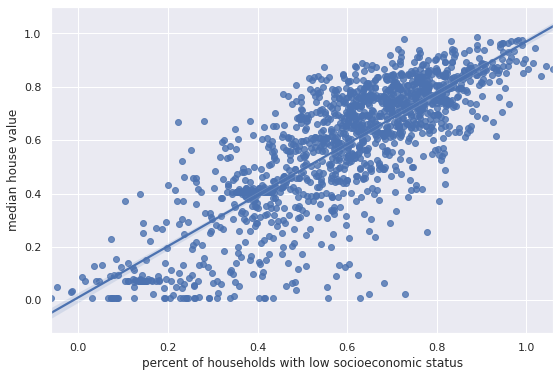

r = 0.816 , p < 0.0


In [253]:
y = y_train["AimoScore"]
X_2 = createExtraPredictors(X_train)

t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y,t).fit()

yt = y_test["AimoScore"]
X_3 = createExtraPredictors(X_test)

t1 = sm.add_constant(X_3, prepend=False)
predicted_2 = model.predict(t1)

res = pd.DataFrame({"Original":yt,"Predicted":predicted_2})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

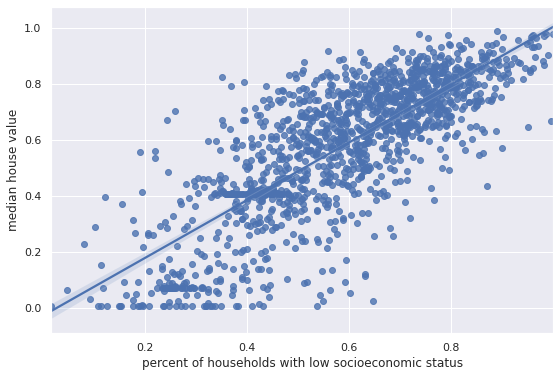

r = 0.785 , p < 1.517256714004291e-305


In [254]:
y = y_train["AimoScore"]
X_2 = X_train.drop(columns=[])
X_2["No_12_NASM_Deviation ^ 2"] = X_2["No_12_NASM_Deviation"] ** 2


t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y,t).fit()

yt = y_test["AimoScore"]
X_3 = X_test.drop(columns=[])
X_3["No_12_NASM_Deviation ^ 2"] = X_3["No_12_NASM_Deviation"] ** 2


t1 = sm.add_constant(X_3, prepend=False)
predicted_3 = model.predict(t1)

res = pd.DataFrame({"Original":yt,"Predicted":predicted_3})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.4 Comparison

### 3.4.1 Comparing the MSRs 

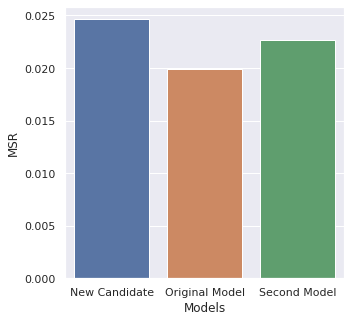

In [255]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(yt, predicted_1)
mse_2 = mean_squared_error(yt, predicted_2)
mse_3 = mean_squared_error(yt, predicted_3)


results = pd.DataFrame({"MSR":[mse_1,mse_2,mse_3],"Models":["New Candidate","Original Model","Second Model"]})

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(5,5))

sns.barplot(data=results, x="Models", y="MSR",ax=ax)

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("MSR")

plt.show()

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(solver='liblinear', C=25.0, random_state=0)
result_3 = model_3.fit(X_train, y_train)

print('Classes: ',result_3.classes_)
print('Intercept :', result_3.intercept_)
print('Coefficeients: ',result_3.coef_)

In [ ]:
prob = result_3.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
dominant = result_3.classes_[maxValues.idxmax(axis=1, skipna=True)]

comparison = pd.DataFrame({'Original': y_test.WeakLinks, 'Dominant':dominant})
comparison

In [ ]:
c,e,p = checkCorrectness(comparison,"Original","Dominant")

print("correct:" + str(c))
print("incorrect:" + str(e))
print("percentage:" + str(p))

In [ ]:
# Save champion model
import joblib

joblib.dump(result_3, "logistic_regression.joblib")

In [ ]:
confusion_matrix = comparison.groupby(['Dominant','Original']).size().unstack('Original').fillna(0)
confusion_matrix

In [ ]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=2

In [ ]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=2)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

In [ ]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=5

In [ ]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=5)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

In [ ]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)